# Example: GBM Net Present Value Trade Rule
In this example, we will implement a trade rule based on the Net Present Value (NPV) where the future share price is modeled using a Geometric Brownian Motion (GBM). The trade rule will generate buy and sell signals based on the NPV of the stock.

> __Learning Objectives:__
>
> * **Calculate return probabilities using GBM and NPV models.** We compute the likelihood of achieving specific return thresholds by combining geometric Brownian motion price models with net present value calculations.
> * **Analyze probability distributions across fractional return thresholds.** We evaluate how success probabilities change for different target returns over defined time horizons using statistical methods and normal distribution functions.
> * **Visualize risk-return relationships for trading analysis.** We create probability plots that show the trade-off between return expectations and success likelihood, providing insights for risk assessment.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, and configures the environment. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for several exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [6]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Next, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

Now, let's load the GBM parameters that we computed in the previous example:

In [14]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [16]:
TSIM = 63; # number of trading days to simulate
Δt = (1.0/252); # step size: 1 trading day in units of years
r̄ = 0.05; # risk-free rate (annualized)

___

## Compute the NPV Trade Rule
In this task, we will compute the NPV trade rule for a selected firm in our dataset, assuming that the future stock price follows a GBM. Let's start by selecting a firm from our dataset. You can change the value of the `selected_firm_ticker::String` variable to analyze a different firm:

In [19]:
selected_firm_ticker = "AAPL"; # test ticker symbol

Next, let's specify a desired fractional return threshold, `f₊::Float64`. We'll experiment with different values of `f₊` later to see how it affects the NPV trade rule:

In [21]:
f₊ = -0.15; # desired fractional return threshold

Now, let's perform a few test calculations and see what happens for different fractional return thresholds, e.g., `f₊ = -0.15` or `f₊ = 0.15`. What do we observe?

In [23]:
let

    # initialize -
    i = findfirst(x-> x==selected_firm_ticker, list_of_tickers); # index of the selected firm
    μ = parameters_df[i,:drift]; # drift parameter
    σ = parameters_df[i,:volatility]; # volatility parameter
    T = TSIM * Δt; # total time (in years)
    d = Normal(); # standard normal distribution
    m = (μ - 0.5*σ^2)*T; # "m" parameter
    v = σ^2*T; # "v" parameter
    
    # compute the probability of f₊ -
    N = log((1.0 + f₊)*exp(r̄*T)) - m; # numerator
    D = sqrt(v); # denominator
    p = 1.0 - cdf(d, N/D); # probability of a positive return
    println("For $(selected_firm_ticker) with f₊=$(f₊), the P(r > f₊) in T = $(TSIM) days is p=$(round(p,digits=4)).");
end

For AAPL with f₊=-0.15, the P(r > f₊) in T = 63 days is p=0.9589.


Our code appears to be working correctly. Now, let's compute the NPV trade rule for a range of desired fractional return thresholds, $r_\star \in [-0.2,0.4]$ (you can change this range if desired).

We'll save the results in the `P::Array{Float64,2}` variable where rows correspond to different values of $r_\star$, the first column contains the value of $r_\star$, and the second column contains the corresponding probability:

In [25]:
P = let

    # initialize -
    i = findfirst(x-> x==selected_firm_ticker, list_of_tickers); # index of the selected firm
    μ = parameters_df[i,:drift]; # drift parameter
    σ = parameters_df[i,:volatility]; # volatility parameter
    T = TSIM * Δt; # total time (in years)
    d = Normal(); # standard normal distribution
    m = (μ - 0.5*σ^2)*T; # "m" parameter
    v = σ^2*T; # "v" parameter
    number_of_points = 201; # number of points in the fractional return range

    f = range(-0.20, stop=0.40, length=number_of_points) |> collect; # range of fractional returns
    P = Array{Float64,2}(undef, number_of_points, 2); # initialize

    for i ∈ eachindex(f)
        # compute the probability of f[i] -
        N = log((1.0 + f[i])*exp(r̄*T)) - m; # numerator
        D = sqrt(v); # denominator
        p = 1.0 - cdf(d, N/D); # probability of a positive return
        P[i,1] = f[i]; # fractional return
        P[i,2] = p; # probability of a positive return
    end

    P;
end;

`Unhide` the code cell below to see how we visualized the cumulative distribution function (CDF) of the NPV trade rule for different values of the desired fractional return threshold, $r_\star$.

> __What do you observe?__ How does the probability change as we vary the desired fractional return threshold, $r_\star$? For $r_\star < 0$, the probability that we observe $\texttt{NPV}(\bar{r},T)/(n_o S_0) > r_\star$ is very high, meaning we are very likely to achieve a negative return. For $r_\star \gg 0$, the probability that we observe $\texttt{NPV}(\bar{r},T)/(n_o S_0) > r_\star$ is much lower, meaning we are less likely to achieve a large positive return.

How can we use this information to make informed trading decisions?

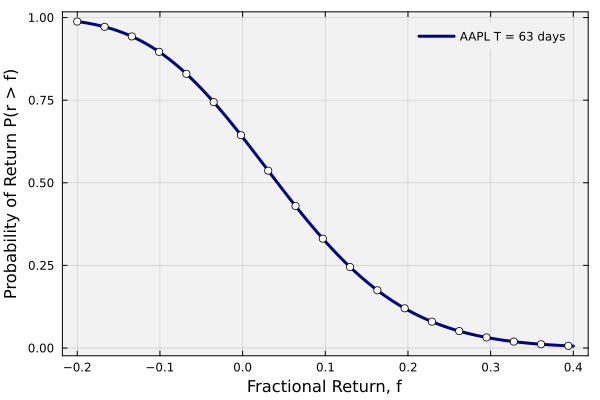

In [27]:
let

    # initialize -
    skip = 11;
    n = size(P,1);

    plot(P[:,1], P[:,2], c=:navy, lw=3, label="$(selected_firm_ticker) T = $(TSIM) days", legend=:topright);
    scatter!(P[1:skip:n,1], P[1:skip:n,2], c=:white, mec=:navy, ms=4, label="");
    xlabel!("Fractional Return, f");
    ylabel!("Probability of Return P(r > f)");

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

## Summary
In this example, we computed return probabilities for GBM-based price models and analyzed how different return thresholds affect the likelihood of trading success.

> __Key Takeaways__
> * **Probability calculations provide quantitative risk assessment tools.** We used geometric Brownian motion models with NPV formulations to compute statistical probabilities of achieving target returns rather than relying on intuition.
>
> * **Return threshold analysis reveals fundamental risk-return trade-offs.** By computing success probabilities across different return targets, we demonstrated the mathematical relationship between higher return expectations and lower success probabilities.
>
> * **Visualization clarifies complex probability relationships.** The cumulative probability distribution plots make abstract statistical concepts concrete, showing how return expectations directly impact the likelihood of trading success.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.